In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import os
import time

In [2]:
IMAGE_SIZE= 224
BATCH_SIZE= 30
CHANNELS= 3
EPOCHS= 30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "grayscale",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 54305 files belonging to 38 classes.


In [4]:
class_names = dataset.class_names
class_names
le = LabelEncoder()
encoded = le.fit_transform(class_names)
encoded = list(encoded)
# encoded_class = {x for x in class_names : y for y in encoded}
encoded_class = {}
for key in class_names:
    for value in encoded:
        encoded_class[key] = value
        encoded.remove(value)
        break
# le.fit_transform(class_names)

In [5]:
len(dataset)

1811

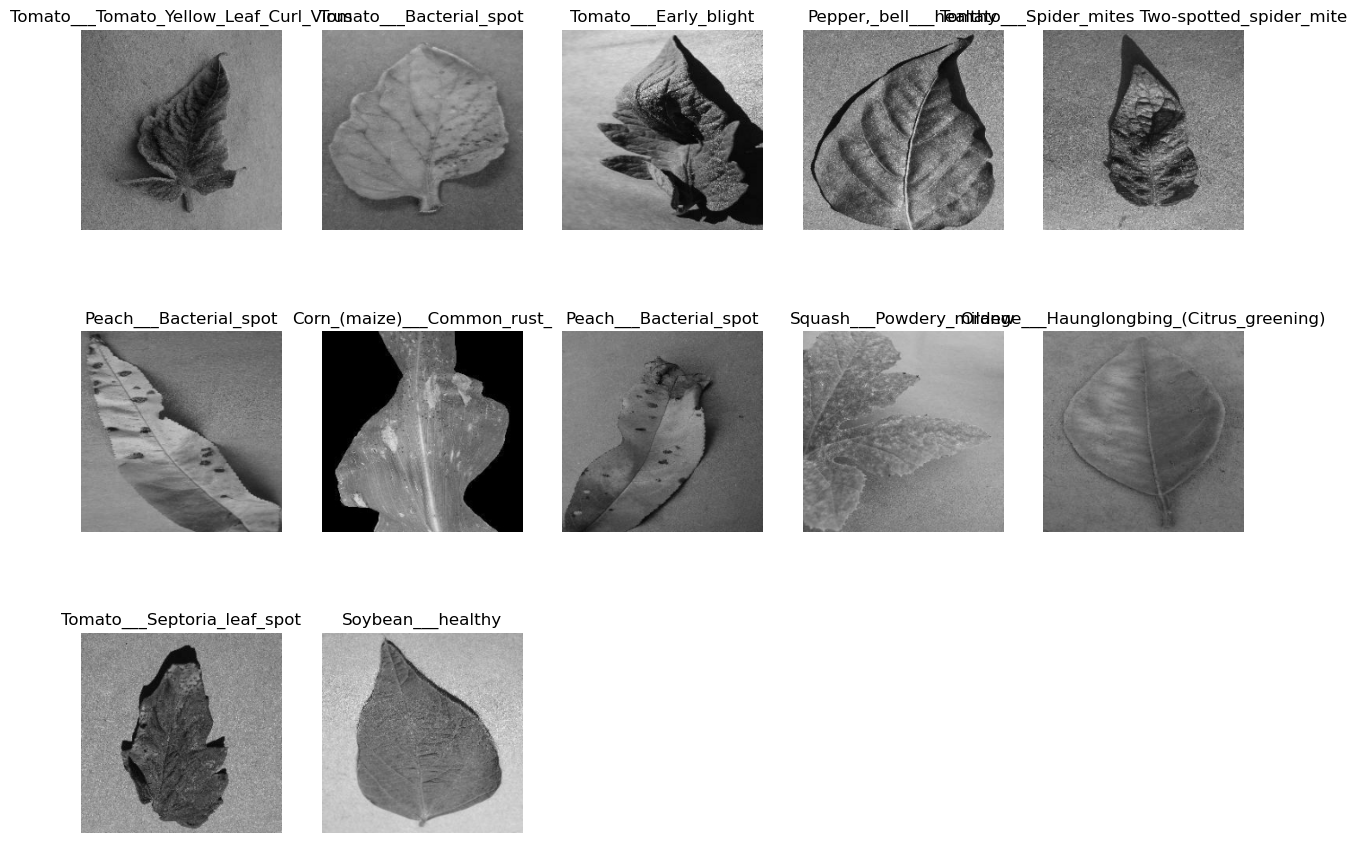

In [6]:
plt.figure(figsize=(15, 15))
for image_batch, label_batch in dataset.take(1):
       for i in range(12): 
        ax = plt.subplot(4,5, i+1)    
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
# 80% ==> training
# 20% ==> 10% validation, 10% test
train_size = 0.8
len(dataset)*train_size

1448.8000000000002

In [8]:
train_ds = dataset.take(1449)
len(train_ds)


1449

In [9]:
test_ds = dataset.skip(1449)
len(test_ds)

362

In [10]:
val_size = 0.1
len(dataset)*val_size

181.10000000000002

In [11]:
val_ds = test_ds.take(182)
len(val_ds)

182

In [12]:
test_ds = dataset.skip(182)
len(test_ds)

1629

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size= len(ds)
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12)
       
    train_size = int(train_split * ds_size)
        
    val_size = int(val_split * ds_size)
        
    train_ds = ds.take(train_size)
        
    val_ds = ds.skip(train_size).take(val_size)
        
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds 

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

1448

In [16]:
len(val_ds)

181

In [17]:
len(test_ds)

182

In [18]:
#optimiztion 
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
import tensorflow as tf

def residual_block(input_tensor, filters, strides=1):
    x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    shortcut = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(input_tensor)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x

def ResNet50(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    filters = 64
    for i in range(3):
        x = residual_block(x, filters)
        filters *= 2

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [20]:
model = ResNet50(input_shape=(224,224,3), num_classes=38)

In [21]:
root_logdir = os.path.join(os.curdir, "logs\\fit\\")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [22]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD

learning_rate = 0.005
decay_rate = learning_rate / 30
sgd = SGD(learning_rate=learning_rate, momentum=0.9, decay=decay_rate, nesterov=False)

model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [23]:
history= model.fit(train_ds,
                   epochs=EPOCHS,
                   batch_size=BATCH_SIZE,
                   verbose=1,
                   validation_data=val_ds,
                   callbacks=[tensorboard_cb]
                  )

C:\Users\kinja\.conda\envs\mk\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/30
1448/1448 [==============================] - 846s 410ms/step - loss: 1.5649 - accuracy: 0.5573 - val_loss: 6.2975 - val_accuracy: 0.2317
Epoch 2/30
1448/1448 [==============================] - 364s 252ms/step - loss: 0.8359 - accuracy: 0.7514 - val_loss: 4.1127 - val_accuracy: 0.3503
Epoch 3/30
1448/1448 [==============================] - 369s 255ms/step - loss: 0.6003 - accuracy: 0.8214 - val_loss: 7.0730 - val_accuracy: 0.1151
Epoch 4/30
1448/1448 [==============================] - 360s 248ms/step - loss: 0.4835 - accuracy: 0.8549 - val_loss: 2.6999 - val_accuracy: 0.3987
Epoch 5/30
1448/1448 [==============================] - 360s 248ms/step - loss: 0.4092 - accuracy: 0.8795 - val_loss: 1.1916 - val_accuracy: 0.6514
Epoch 6/30
1448/1448 [==============================] - 357s 246ms/step - loss: 0.3557 - accuracy: 0.8951 - val_loss: 2.1031 - val_accuracy: 0.5273
Epoch 7/30
1448/1448 [==============================] - 360s 249ms/step - loss: 0.3219 - accuracy: 0.9044 - val_

In [24]:
model.evaluate(test_ds)

182/182 [==============================] - 121s 68ms/step - loss: 0.1777 - accuracy: 0.9419


[0.17771917581558228, 0.9419413805007935]

In [25]:
model_version = 152
model.save(f"../model152/{model_version}")

INFO:tensorflow:Assets written to: ../model152/152\assets


C:\Users\kinja\.conda\envs\mk\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

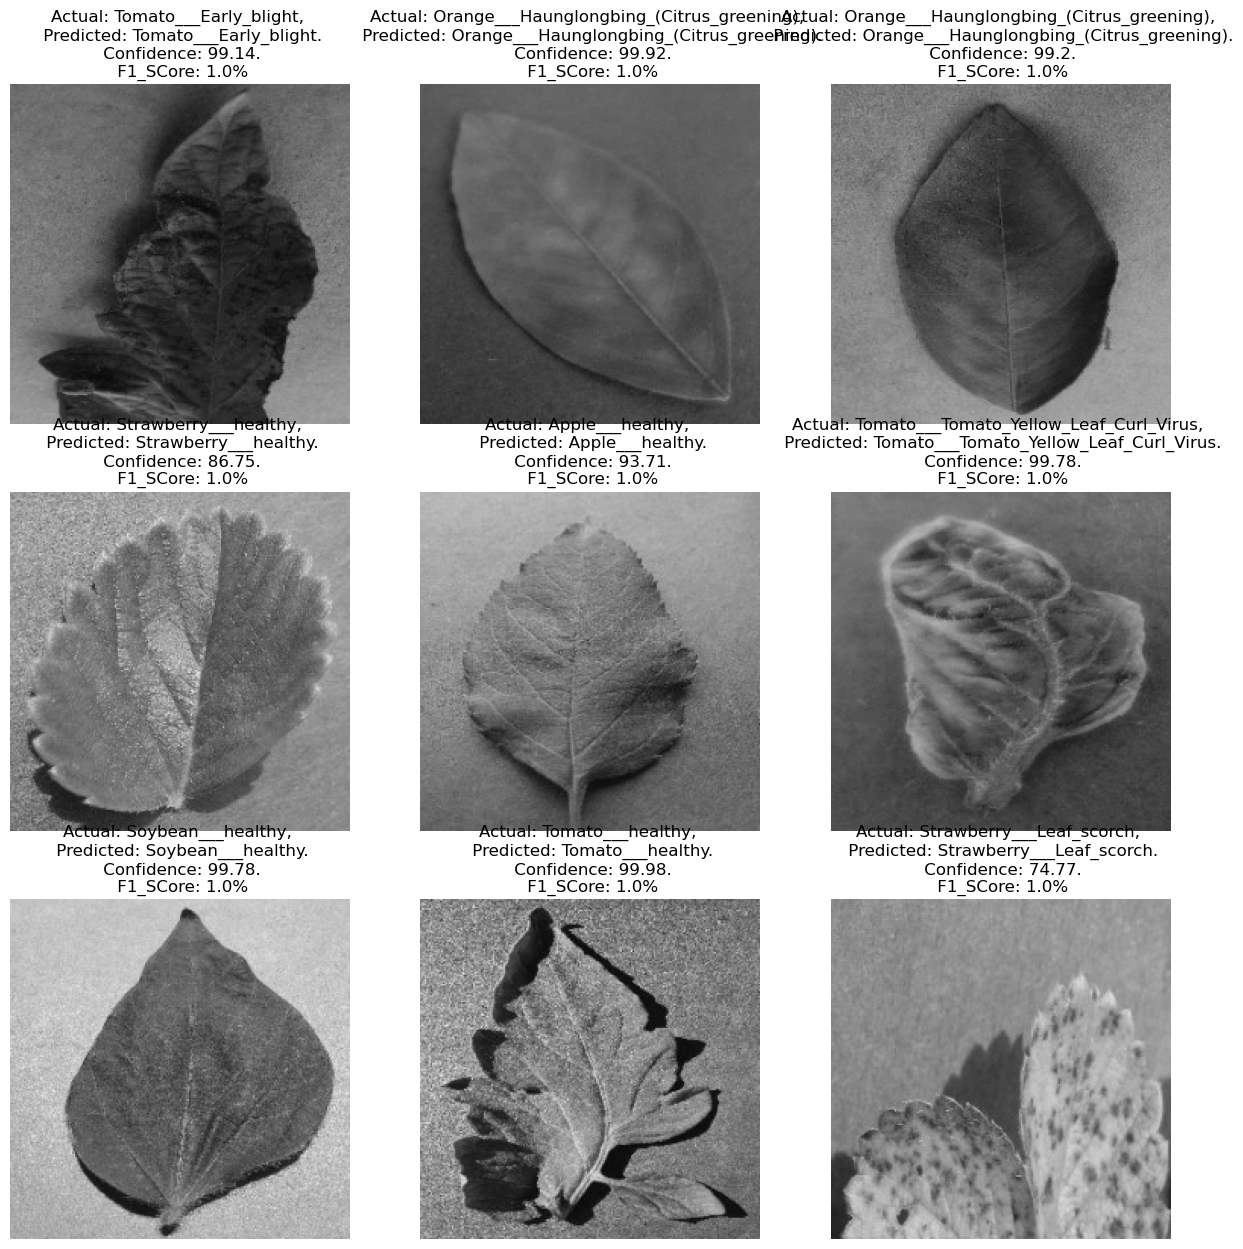

In [27]:
# 1st batch,9 images
import numpy as np
from sklearn.metrics import f1_score
over_all_actual_encoded = []
over_all_predicted_encoded = []

plt.figure(figsize=(15, 15))
for image_batch, label_batch in test_ds.take(10):

    for i in range(9):
        actualencoded = []
        predicted_encoded = []
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, image_batch[i].numpy())
        predicted_encoded.append(encoded_class.get(predicted_class))
#         print(predict(model, image_batch[i].numpy()))
        actual_class = class_names[label_batch[i]]
        actualencoded.append(encoded_class.get(actual_class))
        over_all_actual_encoded.append(encoded_class.get(actual_class))
        over_all_predicted_encoded.append(encoded_class.get(predicted_class))
        f1 = f1_score(actualencoded,predicted_encoded,average = 'micro')
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}.\n F1_SCore: {f1}%")
        
        plt.axis("off")

In [28]:
f1_score(over_all_actual_encoded,over_all_predicted_encoded,average = 'micro')

0.9666666666666667

In [29]:
# equivalent to: model.save("model.h5")
from tensorflow.keras.models import save_model
save_model(model, "model_ResNet50_gray_V4_80_20.h5")

C:\Users\kinja\.conda\envs\mk\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
